In [1416]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dython.nominal import associations
from mlxtend.plotting import plot_decision_regions
from itertools import chain
import math

sns.set_style('darkgrid')
%matplotlib inline

In [1417]:
import warnings
import time
warnings.filterwarnings("ignore")

## Side Note

1. $s\in\{\text{Caucasian, } \text{African-American}\}$ is the sensitive attribute
2. $y$: “two_year_recid” column is the target
3. $e_i\subset X$ is the explanatory attribute that is (cor)related with the sensitive attribute s, and at the same time gives some objective information about the label y.

## Ground ETL

In [1418]:
raw_data = '/Users/fuwang/Documents/Columbia University/Fall 2022/STAT5243/Project4/Data/compas-scores-two-years.csv'

In [1419]:
df = pd.read_csv(raw_data)

In [1420]:
df.shape

(7214, 53)

In [1421]:
df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [1422]:
df.race.unique()

array(['Other', 'African-American', 'Caucasian', 'Hispanic',
       'Native American', 'Asian'], dtype=object)

In [1423]:
# include only the required two races
data = df[(df['race']=='African-American')|(df['race']=='Caucasian')]

In [1424]:
data.shape

(6150, 53)

In [1425]:
data.keys()

Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event', 'two_year_recid'],
      dtype='object')

In [1426]:
# Select the useful keys for ML

In [1427]:
data.shape

(6150, 53)

In [1428]:
data.isna().sum().sort_values(ascending=False)

violent_recid              6150
vr_charge_degree           5433
vr_case_number             5433
vr_offense_date            5433
vr_charge_desc             5433
c_arrest_date              5165
r_jail_out                 4087
r_jail_in                  4087
r_days_from_arrest         4087
r_charge_desc              3141
r_offense_date             3089
r_case_number              3089
r_charge_degree            3089
c_offense_date              999
c_jail_out                  235
days_b_screening_arrest     235
c_jail_in                   235
out_custody                 180
in_custody                  180
c_charge_desc                21
c_days_from_compas           14
c_case_number                14
v_type_of_assessment          0
type_of_assessment            0
decile_score.1                0
v_decile_score                0
v_score_text                  0
v_screening_date              0
screening_date                0
priors_count.1                0
start                         0
end     

In [1429]:
data['type_of_assessment'].unique()

array(['Risk of Recidivism'], dtype=object)

Some columns have way too many missing values, theoretically, 25 to 30% is the maximum missing values are allowed, beyond which we might want to drop the variable from analysis. Thus, here we'd like to drop any columns with more than 999 missing values

In [1430]:
data.drop(['violent_recid','vr_charge_degree','vr_case_number','vr_offense_date','vr_charge_desc',
          'c_arrest_date','r_jail_out','r_jail_in','r_days_from_arrest','r_charge_desc',
          'r_offense_date','r_case_number','r_charge_degree'], axis=1,inplace=True)

In [1431]:
data.isna().sum().sort_values(ascending=False)

c_offense_date             999
days_b_screening_arrest    235
c_jail_out                 235
c_jail_in                  235
out_custody                180
in_custody                 180
c_charge_desc               21
c_case_number               14
c_days_from_compas          14
v_score_text                 0
v_decile_score               0
is_recid                     0
screening_date               0
score_text                   0
decile_score.1               0
v_screening_date             0
priors_count.1               0
start                        0
end                          0
event                        0
type_of_assessment           0
is_violent_recid             0
v_type_of_assessment         0
id                           0
c_charge_degree              0
name                         0
priors_count                 0
juv_other_count              0
juv_misd_count               0
decile_score                 0
juv_fel_count                0
race                         0
age_cat 

In [1432]:
data['event']

1       1
2       0
3       0
6       1
8       0
       ..
7207    1
7208    0
7209    0
7210    0
7212    0
Name: event, Length: 6150, dtype: int64

In [1433]:
type(data['out_custody'].iloc[0])

str

Convert str to datetime

In [1434]:
data['c_offense_date'] = pd.to_datetime(data['c_offense_date'])
data['c_jail_in']= pd.to_datetime(data['c_jail_in'])
data['c_jail_out']= pd.to_datetime(data['c_jail_out'])
data['out_custody']= pd.to_datetime(data['out_custody'])
data['in_custody']= pd.to_datetime(data['in_custody'])
data['screening_date']= pd.to_datetime(data['screening_date'])
data['compas_screening_date']= pd.to_datetime(data['compas_screening_date'])
data['v_screening_date']= pd.to_datetime(data['v_screening_date'])

Fill NA

In [1435]:
data['c_days_from_compas'] = data['c_days_from_compas'] .fillna(data['c_days_from_compas'].mode()[0])

In [1436]:
X = data.drop(['id','two_year_recid','c_case_number','sex','dob','name'], axis=1)

In [1437]:
X.set_index(data.id,inplace=True)

In [1438]:
af = data[data.race=='African-American']
ca = data[data.race =='Caucasian']

In [1439]:
rate_af = round(af[af['two_year_recid']==1].shape[0]/af.shape[0],2)

In [1440]:
rate_ca = round(ca[ca['two_year_recid']==1].shape[0]/af.shape[0],2)

In [1441]:
print(f'The rate of Recidivism for African-American is {rate_af}\nThe rate of Recidivism for Caucasian is {rate_ca}')
print(f'The Corrected Recidivism rate should be {(rate_af+rate_ca)/2:,} ')

The rate of Recidivism for African-American is 0.51
The rate of Recidivism for Caucasian is 0.26
The Corrected Recidivism rate should be 0.385 


In [1442]:
y = data[['two_year_recid']]

In [1443]:
y.set_index(data.id,inplace=True)

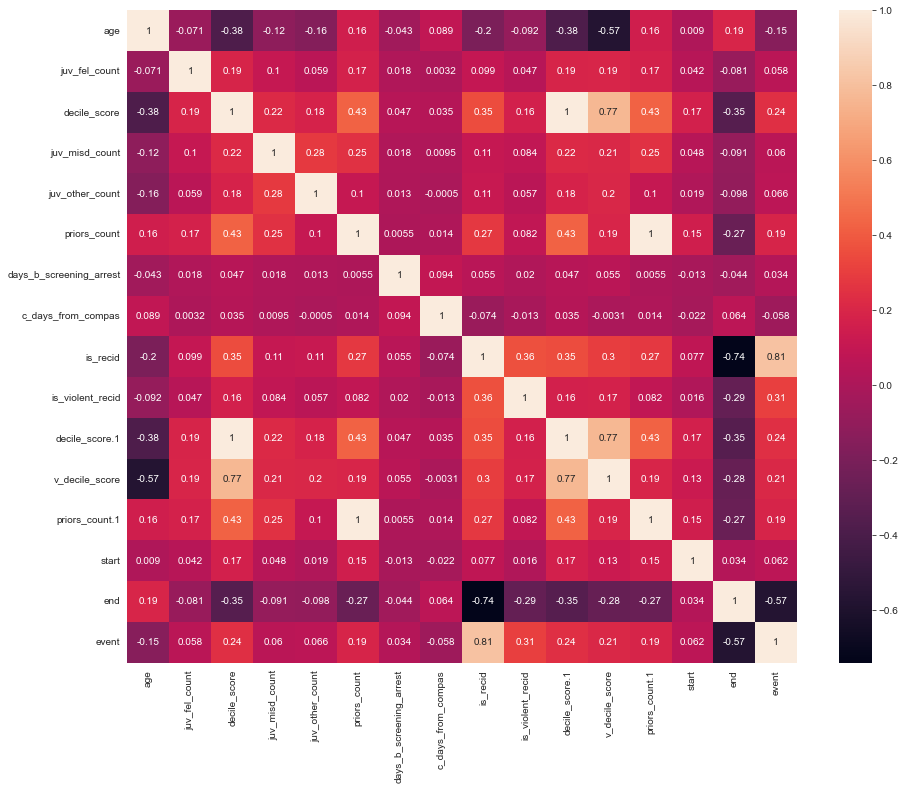

In [1444]:
corr = X.corr()
fig,ax = plt.subplots(figsize=(15,12))
sns.heatmap(corr, annot=True)
plt.show()

In [1445]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.calibration import CalibratedClassifierCV

In [1446]:
enc = OneHotEncoder(handle_unknown='ignore')

In [1447]:
X_new = enc.fit(X)
X_new = enc.transform(X)

In [1448]:
X_train, X_test, y_train, y_test = train_test_split(X_new,y,test_size=.3,random_state=44)

In [1449]:
forest = RandomForestClassifier(random_state=44).fit(X_train, y_train) 

In [1450]:
y_pred_test = forest.predict(X_test)

Accuracy

In [1451]:
accuracy_score(y_test, y_pred_test)

0.9766937669376694

In [1452]:
confusion_matrix(y_test, y_pred_test)

array([[932,  43],
       [  0, 870]])

Calibration

In [1453]:
cali_X = X.loc[y_test.index]
cali_X['label'] = y_test
cali_X['pred'] = y_pred_test

In [1454]:
af_X = cali_X[cali_X.race=='African-American']
ca_X =  cali_X[cali_X.race=='Caucasian']

In [1455]:
np.abs(accuracy_score(af_X.label, af_X.pred)-accuracy_score(ca_X.label, ca_X.pred))

0.02107992678462478

The model showed that African-American has a higher Recidivism rate compared to Caucasian, and in reality the rate should be pretty much the same

In [1456]:
X.isna().sum().sort_values(ascending=False)

c_offense_date             999
days_b_screening_arrest    235
c_jail_out                 235
c_jail_in                  235
out_custody                180
in_custody                 180
c_charge_desc               21
decile_score.1               0
score_text                   0
screening_date               0
v_decile_score               0
v_type_of_assessment         0
is_violent_recid             0
v_score_text                 0
v_screening_date             0
priors_count.1               0
start                        0
end                          0
type_of_assessment           0
first                        0
is_recid                     0
last                         0
c_charge_degree              0
c_days_from_compas           0
priors_count                 0
juv_other_count              0
juv_misd_count               0
decile_score                 0
juv_fel_count                0
race                         0
age_cat                      0
age                          0
compas_s

In [1457]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6150 entries, 3 to 11000
Data columns (total 34 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   first                    6150 non-null   object        
 1   last                     6150 non-null   object        
 2   compas_screening_date    6150 non-null   datetime64[ns]
 3   age                      6150 non-null   int64         
 4   age_cat                  6150 non-null   object        
 5   race                     6150 non-null   object        
 6   juv_fel_count            6150 non-null   int64         
 7   decile_score             6150 non-null   int64         
 8   juv_misd_count           6150 non-null   int64         
 9   juv_other_count          6150 non-null   int64         
 10  priors_count             6150 non-null   int64         
 11  days_b_screening_arrest  5915 non-null   float64       
 12  c_jail_in                5915 non

In [1458]:
categorical_features = ['first','last','age_cat','race','c_charge_degree','c_charge_desc','type_of_assessment',
                       'score_text','v_type_of_assessment','v_score_text']

In [1459]:
selected_column= X[categorical_features]
categorical_df = selected_column.copy()

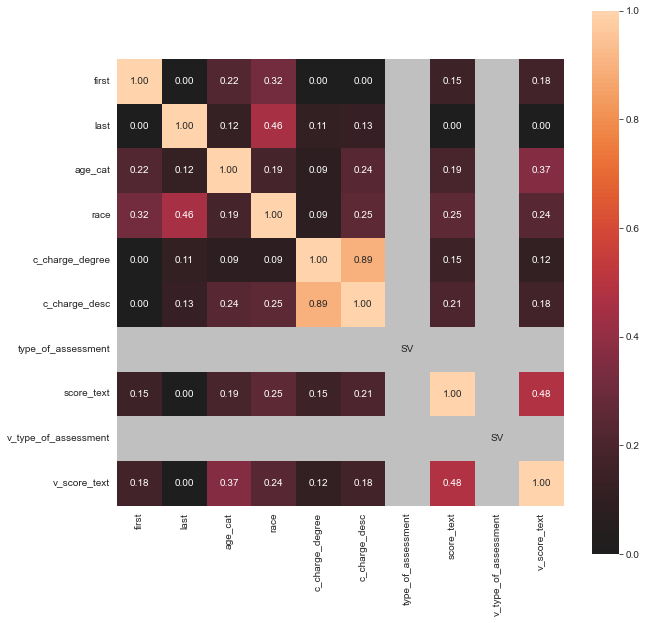

In [1460]:
categorical_correlation= associations(categorical_df, filename= 'categorical_correlation.png', figsize=(10,10))

Here we set the correlation threshold to be no less than 0.2, and we get the $e_{i}$ to be first, last, c_charge_desc, score_text and v_score_text

In [1461]:
e_list = ['first', 'last', 'c_charge_desc', 'score_text' , 'v_score_text']

In [1462]:
exclude_e_s = [
 'compas_screening_date',
 'age',
 'age_cat',
 'juv_fel_count',
 'decile_score',
 'juv_misd_count',
 'juv_other_count',
 'priors_count',
 'days_b_screening_arrest',
 'c_jail_in',
 'c_jail_out',
 'c_offense_date',
 'c_days_from_compas',
 'c_charge_degree',
 'is_recid',
 'is_violent_recid',
 'type_of_assessment',
 'decile_score.1',
 'screening_date',
 'v_type_of_assessment',
 'v_decile_score',
 'v_screening_date',
 'in_custody',
 'out_custody',
 'priors_count.1',
 'start',
 'end',
 'event']

In [1463]:
e = X[e_list]

In [1464]:
new_X = X[exclude_e_s]

In [1465]:
s = X[['race']]

In [1466]:
X.shape

(6150, 34)

In [1467]:
y.shape

(6150, 1)

# Handling Conditional Discrimation

## Algorithm 3


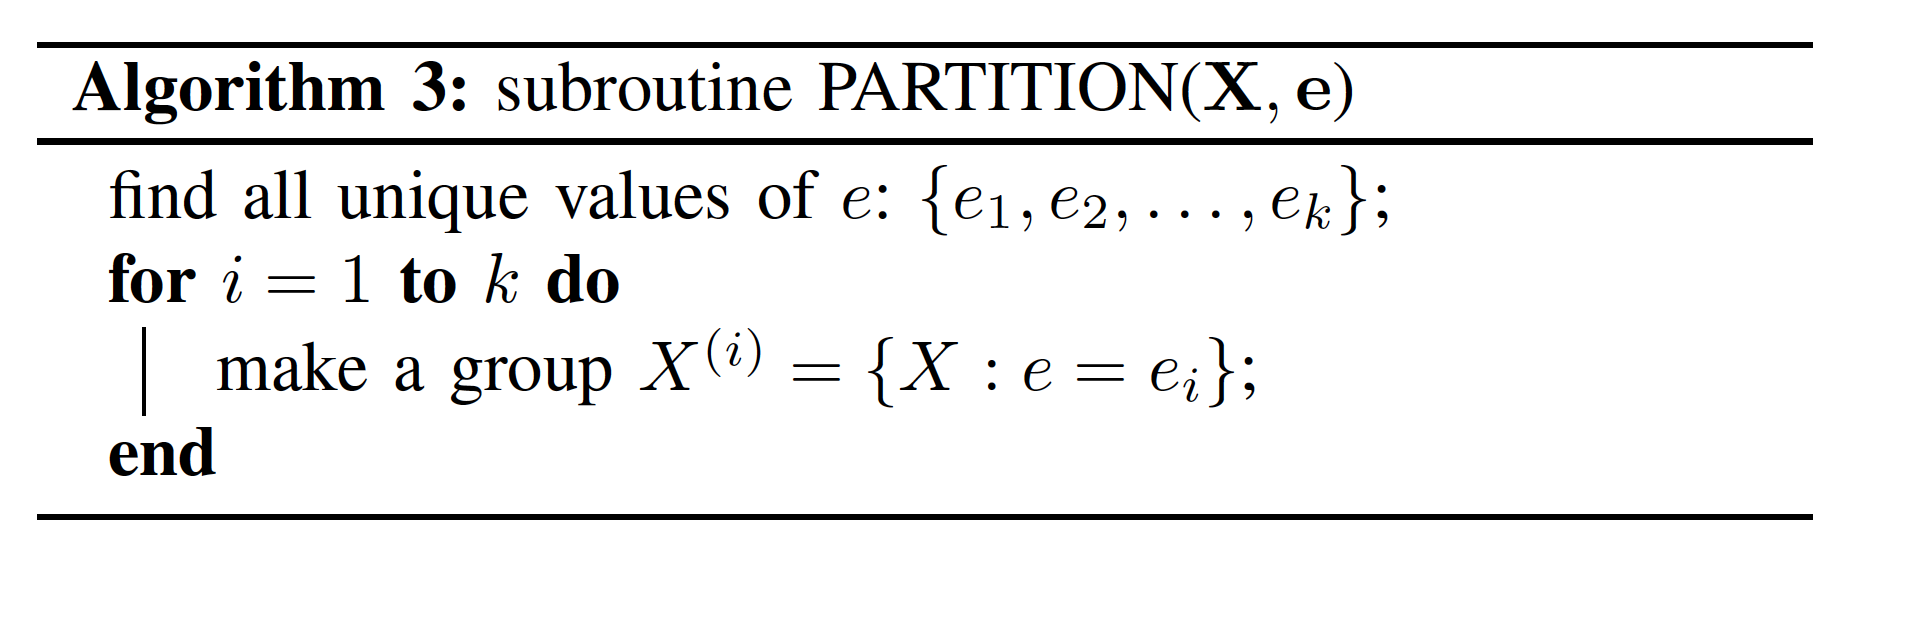

In [1468]:
def partition(X,e):
    e_list = list(e.keys())
    X_i = []
    for i in range(len(e_list)):
        X[e_list[i]] = e[e_list[i]]
        X_i.append(X)
    return X_i

In [1469]:
temp = partition(new_X,e)

In [1470]:
temp[0].shape

(6150, 33)

## Algorithm 4

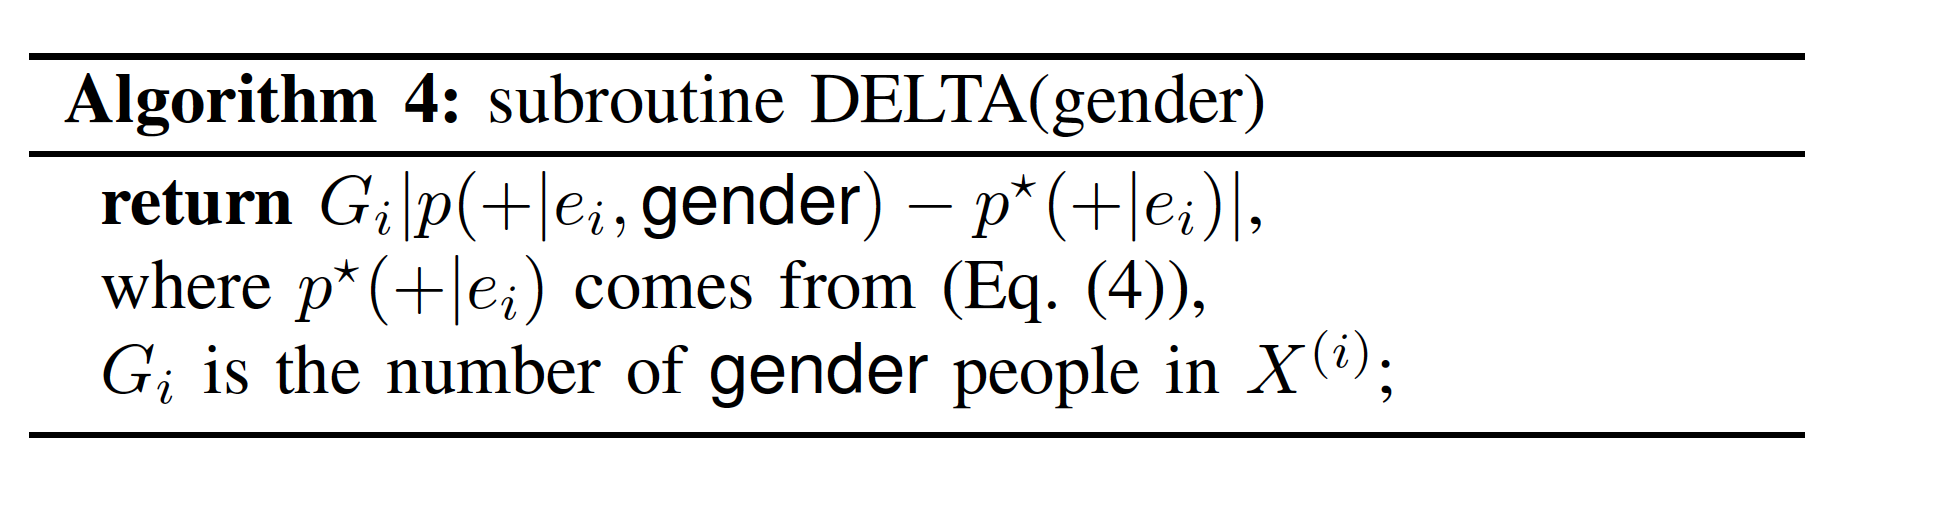


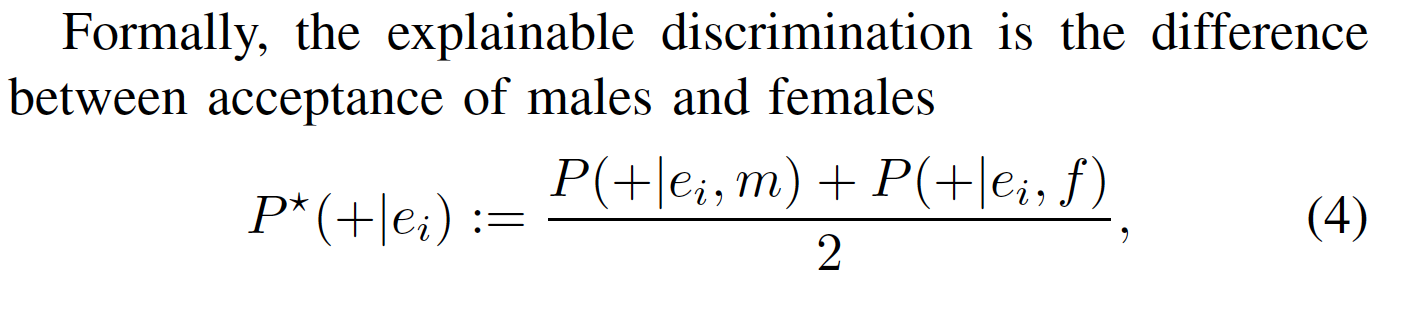

For Algorithm 4, $p^\star(+|e_i)$, $p(+|e_i,\text{gender})$ is changed each time for different i, I have no idea what $G_i$ is the description is too abstract, as so I will define $G_i$ as a constant $C$ (Hyperparameter)

In [1471]:
 def ceildiv(a, b):
    return -(a // -b)

In [1472]:
def delta(item, y_pred, y_prob, G_i = 12):
    
    item_copy = item.copy()
    item_copy['label'] = y_pred
    af = item_copy[item_copy.race=='African-American']
    ca = item_copy[item_copy.race =='Caucasian']
    rate_af = round(af[af['label']==1].shape[0]/af.shape[0],2)
    rate_ca = round(ca[ca['label']==1].shape[0]/ca.shape[0],2)
    p_star = (rate_af+rate_ca)/2
    threshold = np.abs(rate_af-p_star)
    
    test_df = pd.DataFrame(y_prob,columns=['No','Yes'])
    test_df.set_index(item.index,inplace=True)
    test_df['race']=item['race']
    test_df['label'] = y_pred
    temp = test_df[(np.abs(test_df.Yes - test_df.No)<=G_i*threshold)]
#     print(temp.shape[0],threshold)
    for i in range(temp.shape[0]):
        if temp.race.iloc[i] == 'African-American' and temp.Yes.iloc[i] > temp.No.iloc[i]:
            temp.label.iloc[i] = 0
        elif temp.race.iloc[i] == 'Caucasian' and temp.Yes.iloc[i] < temp.No.iloc[i]:
            temp.label.iloc[i] = 1
    
    item_copy['label'].loc[temp.index] = temp.label
    
    return item_copy

In [1473]:
def delta2(item, y_pred, y_prob, G_i = 6):
    
    item_copy = item.copy()
    item_copy['label'] = y_pred
    af = item_copy[item_copy.race=='African-American']
    ca = item_copy[item_copy.race =='Caucasian']
    rate_af = round(af[af['label']==1].shape[0]/af.shape[0],2)
    rate_ca = round(ca[ca['label']==1].shape[0]/ca.shape[0],2)
    p_star = (rate_af+rate_ca)/2
    threshold = np.abs(rate_af-p_star)
    
    test_df = pd.DataFrame(y_prob,columns=['No','Yes'])
    test_df.set_index(item.index,inplace=True)
    test_df['race']=item['race']
    test_df['label'] = y_pred
    temp = test_df[(np.abs(test_df.Yes - test_df.No)<=G_i*threshold)]
#     print(temp.shape[0],threshold)
    temp_dic = temp[['race','label']].value_counts().to_dict()
    
    aa_0,aa_1,ca_0,ca_1 = 0,0,0,0
    for key, value in zip(temp_dic.keys(),temp_dic.values()):
        if key == ('African-American', 1):
            aa_1 = ceildiv(value,2)
        if key == ('African-American', 0):
            aa_0 = ceildiv(value,2)       
        if key == ('Caucasian', 1):
            ca_1 = ceildiv(value,2)        
        if key == ('Caucasian', 0):
            ca_0 = ceildiv(value,2)

    if aa_1>aa_0:
        aa_replace = aa_0
    else:
        aa_replace = aa_1

    if ca_1>ca_0:
        ca_replace = ca_0
    else:
        ca_replace = ca_1

    count_aa = 0
    count_ca = 0

    while(count_aa<aa_replace):
        for idx in list(temp.index):
            if temp.race.loc[idx] == 'African-American' and temp.label.loc[idx] ==1:
                temp.label.loc[idx] = 0
                count_aa +=1

    while(count_ca<ca_replace):
        for idx in list(temp.index):
            if temp.race.loc[idx] == 'Caucasian' and temp.label.loc[idx] ==0:
                temp.label.loc[idx] = 1
                count_ca +=1
    
    item_copy['label'].loc[temp.index] = temp.label
    
    return item_copy

## Algorithm 1

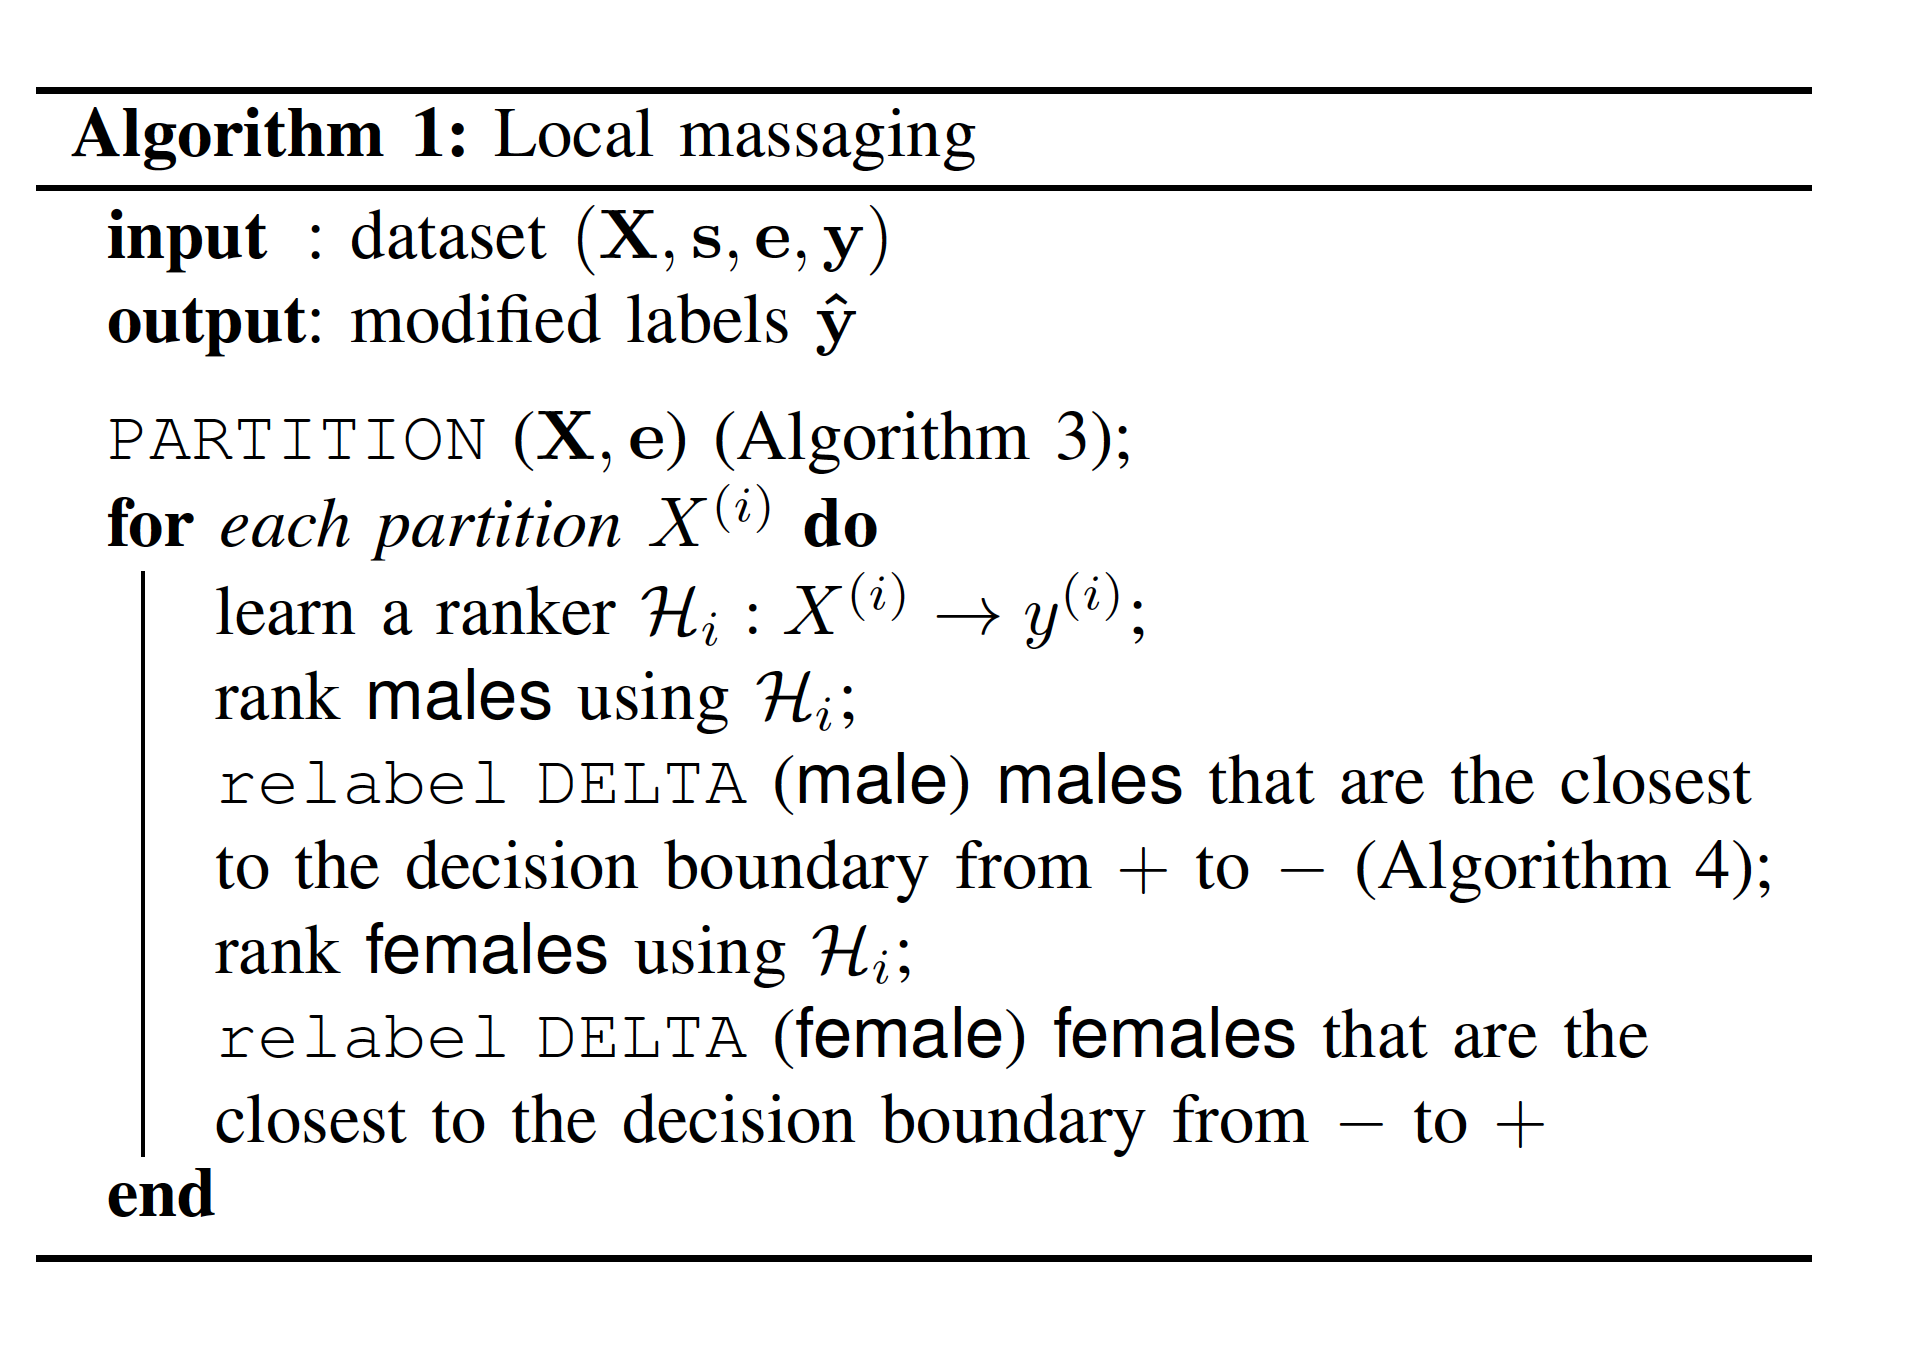

In [1474]:
def local_massaging(X,s,e,y):
    X['race'] = s
    X_i_list =partition(X,e)
    df_list = []
    pd_list = []
    for item in X_i_list:
        enc = OneHotEncoder(handle_unknown='ignore')
        X_new = enc.fit(item)
        X_new = enc.transform(item)
        X_train, X_test, y_train, y_test = train_test_split(X_new,y,test_size=.3,random_state=5)
        forest = RandomForestClassifier(random_state=44).fit(X_train, y_train) 
        y_pred = forest.predict(X_new)
        y_prob = forest.predict_proba(X_new)
        temp_df = delta(item,y_pred,y_prob)
        pd_list.append(temp_df)
        df_list.append(temp_df[['label']])
    
    # Here we take vote 
    
    result = pd.concat(df_list,axis = 1)
    result.loc[result.sum(axis=1)<=2,'new_label'] = 0
    result.loc[result.sum(axis=1)>=3,'new_label'] = 1
    X['new_label'] = result.new_label
    return X

In [1475]:
New_X = local_massaging(new_X,s,e,y)

In [1476]:
af = New_X[New_X.race=='African-American']
ca = New_X[New_X.race =='Caucasian']
rate_af = round(af[af['new_label']==1].shape[0]/af.shape[0],2)
rate_ca = round(ca[ca['new_label']==1].shape[0]/ca.shape[0],2)

In [1477]:
rate_af,rate_ca 

(0.45, 0.43)

We can see the discrimation is being balanced 

In [1478]:
New_y = New_X.new_label
New_X_copy = New_X.copy()
New_X_copy.drop(['new_label'],axis=1,inplace=True)

In [1479]:
X_new = enc.fit(New_X_copy)
X_new = enc.transform(New_X_copy)

In [1480]:
X_train, X_test, y_train, y_test = train_test_split(X_new,New_y,test_size=.3,random_state=42)

In [1481]:
forest = RandomForestClassifier(random_state=42).fit(X_train, y_train) 

In [1482]:
y_pred_test = forest.predict(X_test)

Accuracy

In [1483]:
accuracy_score(y_test, y_pred_test)

0.9371273712737127

In [1484]:
confusion_matrix(y_test, y_pred_test)

array([[931,  88],
       [ 28, 798]])

Calibration

In [1485]:
cali_X = New_X.loc[y_test.index]
cali_X['label'] = y_test
cali_X['pred'] = y_pred_test

In [1486]:
af_X = cali_X[cali_X.race=='African-American']
ca_X =  cali_X[cali_X.race=='Caucasian']

In [1487]:
np.abs(accuracy_score(af_X.label, af_X.pred)-accuracy_score(ca_X.label, ca_X.pred))

0.06605993748850891

## Algorithm 2

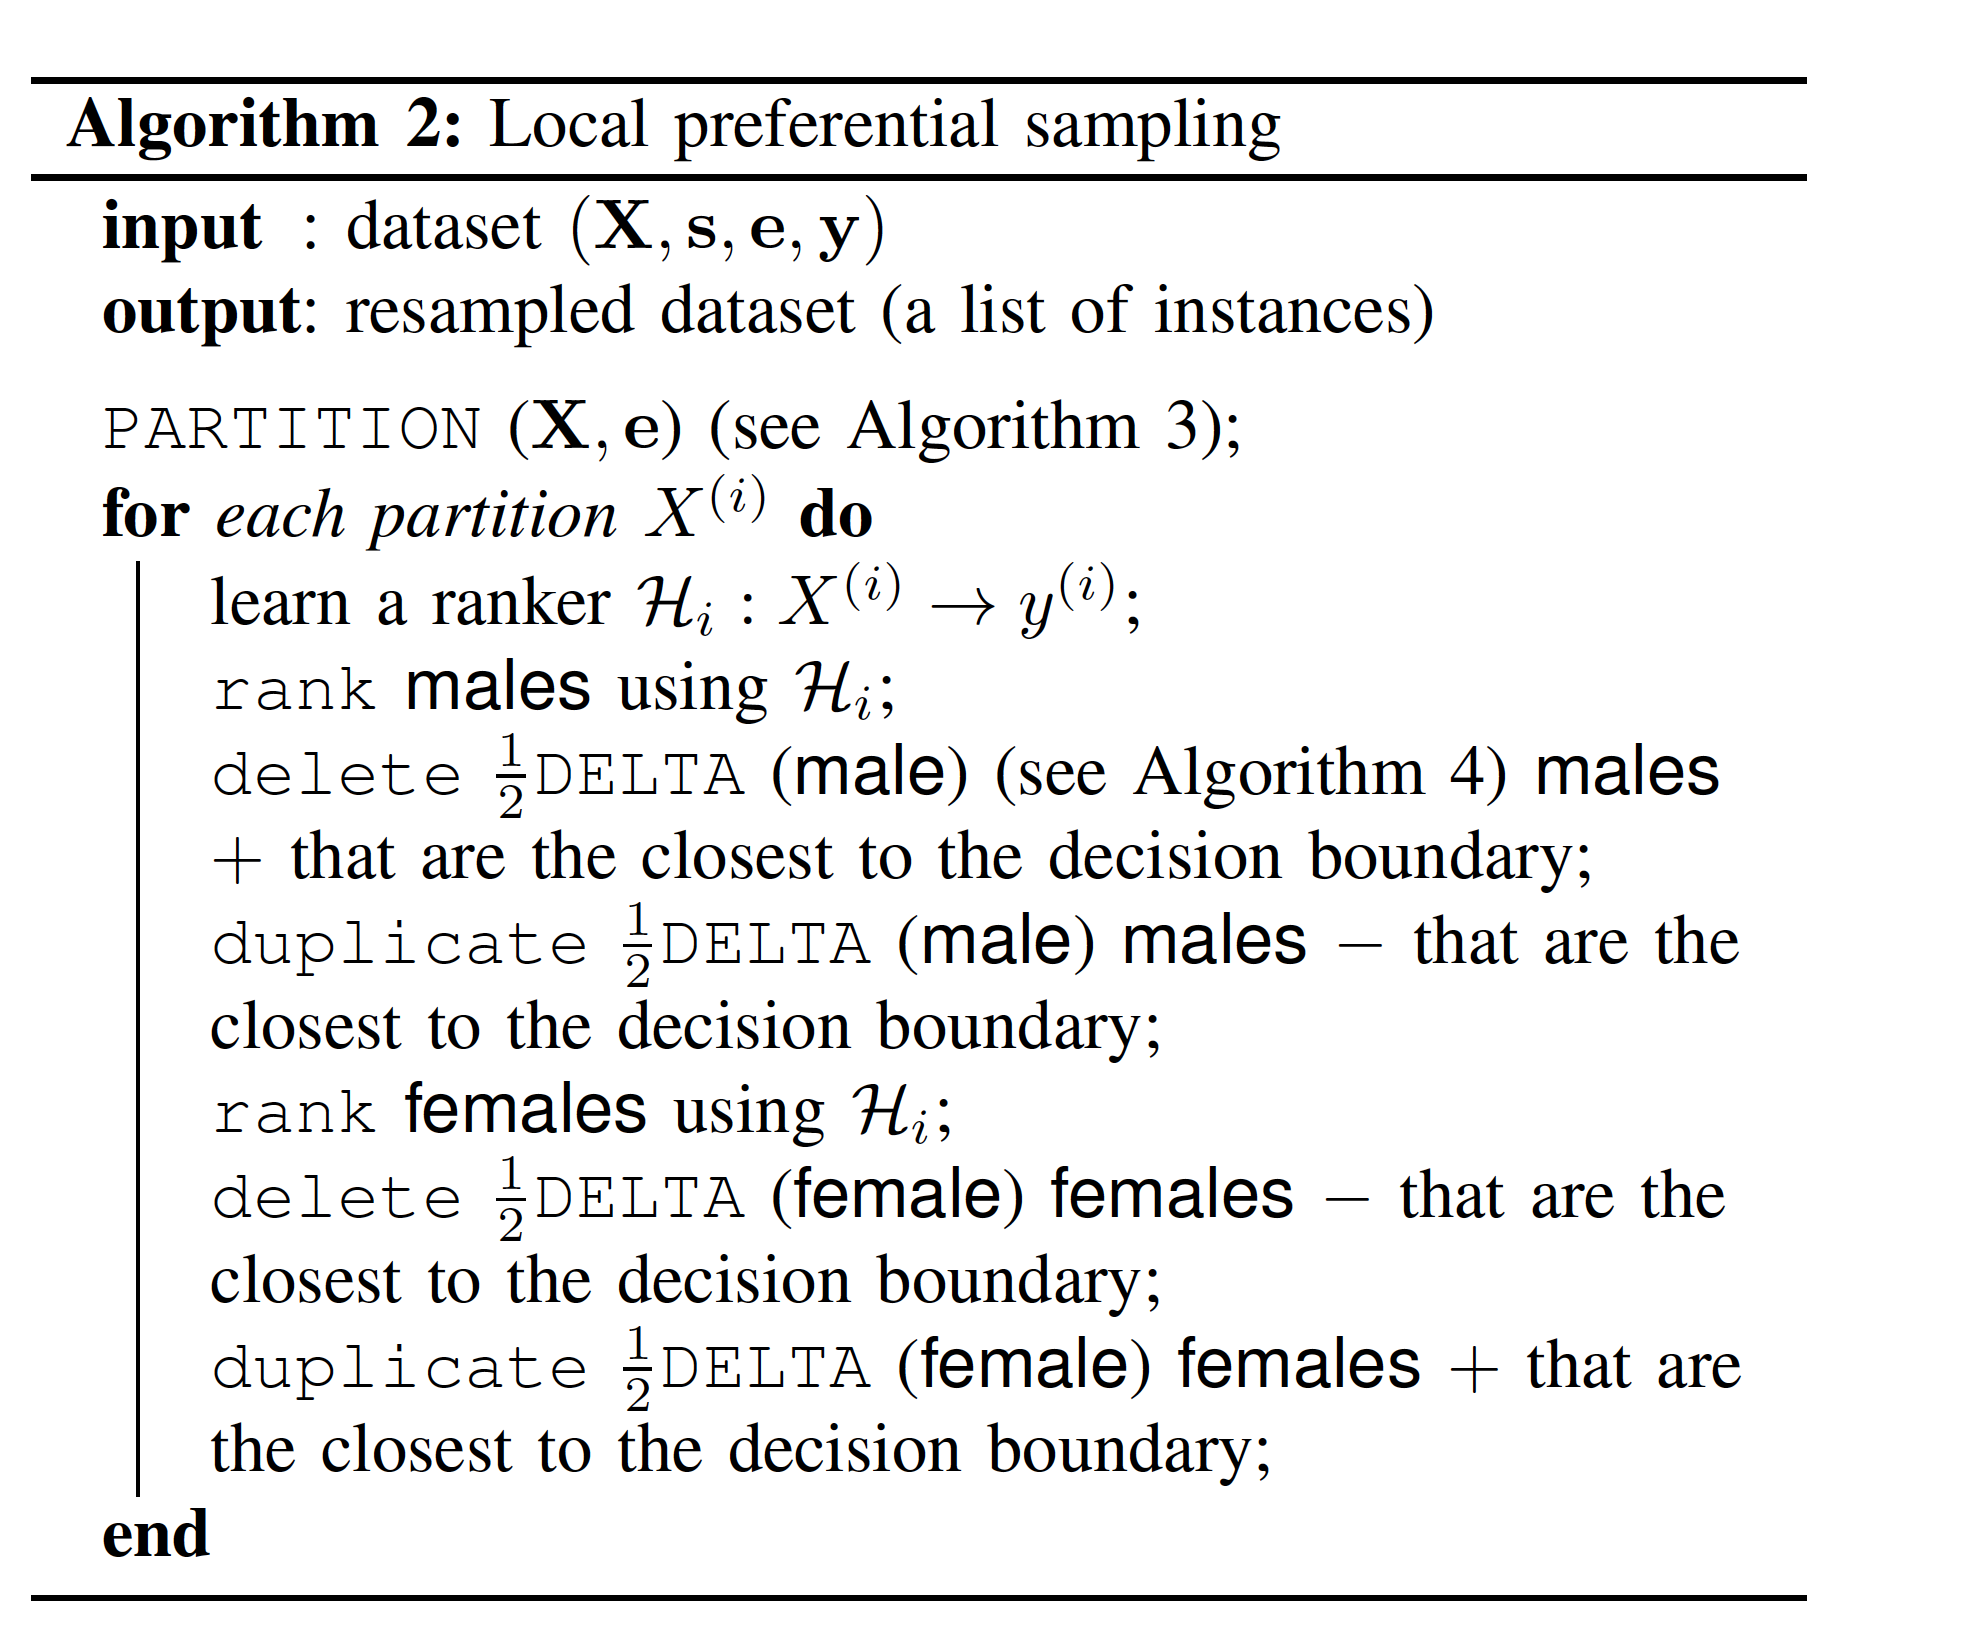

In [1488]:
def local_preferential_sampleing(X,s,e,y):
    X['race'] = s
    X_i_list =partition(X,e)
    df_list = []
    pd_list = []
    for item in X_i_list:
        enc = OneHotEncoder(handle_unknown='ignore')
        X_new = enc.fit(item)
        X_new = enc.transform(item)
        X_train, X_test, y_train, y_test = train_test_split(X_new,y,test_size=.3,random_state=42)
        forest = RandomForestClassifier(random_state = 88).fit(X_train, y_train) 
        y_pred = forest.predict(X_new)
        y_prob = forest.predict_proba(X_new)
        temp_df = delta2(item,y_pred,y_prob,6)
        pd_list.append(temp_df)
        df_list.append(temp_df[['label']])
    
    # Here we take vote 
    
    result = pd.concat(df_list,axis = 1)
    result.loc[result.sum(axis=1)<=2,'new_label'] = 0
    result.loc[result.sum(axis=1)>=3,'new_label'] = 1
    X['new_label'] = result.new_label
    
    return X

In [1489]:
X_New = local_preferential_sampleing(new_X,s,e,y)

In [1490]:
af = X_New[X_New.race=='African-American']
ca = X_New[X_New.race =='Caucasian']
rate_af = round(af[af['new_label']==1].shape[0]/af.shape[0],2)
rate_ca = round(ca[ca['new_label']==1].shape[0]/ca.shape[0],2)

In [1491]:
rate_af,rate_ca

(0.5, 0.41)

We can see the discrimation is being balanced 

In [1492]:
y_New = X_New.new_label
X_New_copy = X_New.copy()
X_New_copy.drop(['new_label'],axis=1,inplace=True)

In [1493]:
X_new = enc.fit(X_New_copy)
X_new = enc.transform(X_New_copy)

In [1494]:
X_train, X_test, y_train, y_test = train_test_split(X_new,y_New,test_size=.3,random_state=42)

In [1495]:
forest = RandomForestClassifier(random_state=42).fit(X_train, y_train) 

In [1496]:
y_pred_test = forest.predict(X_test)

Accuracy

In [1497]:
accuracy_score(y_test, y_pred_test)

0.9420054200542005

In [1498]:
confusion_matrix(y_test, y_pred_test)

array([[917,  86],
       [ 21, 821]])

Calibration

In [1499]:
cali_X = X_New.loc[y_test.index]
cali_X['label'] = y_test
cali_X['pred'] = y_pred_test

In [1500]:
af_X = cali_X[cali_X.race=='African-American']
ca_X =  cali_X[cali_X.race=='Caucasian']

In [1501]:
np.abs(accuracy_score(af_X.label, af_X.pred)-accuracy_score(ca_X.label, ca_X.pred))

0.05569038426181283

## Conclusion:
We can see that the accuracy and Calibration slightly decreased after modified algorithms but in return of a good elimination towards bad discrimination. After all we conclude that the drop of accuracy is worth the shot.